In [1]:
import sys
sys.path.append('../src')
sys.path.append('../src/data/')
sys.path.append('../src/models/')
sys.path.append('../src/features/')
sys.path.append('../src/visualization/')
# will reload any library
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [18]:
from data.metrics import recall
from visualization.plot_utils import write_latex_table, summary_pooling_table, pooling_plots, pandas_settings, plot_settings,  save_result
# general
import pandas as pd
import numpy as np
from tqdm import tqdm
from features.tracks_info import TrackInfo
from collections import OrderedDict
from itertools import product
from data_utils import product_size
import matplotlib.pyplot as plt
import seaborn as sns

def pool_stats(pid,k,strat,n_pick,true_t,pool_t,true_a,pool_a):
    r_t = recall(true_t, pool_t)
    r_a = recall(true_a, pool_a)
    return OrderedDict([('pid',pid),('k',k),('strategy',strat),('n',n_pick),('recall-tracks',r_t),('recall-artist',r_a)])

plot_settings()
pandas_settings()

# create pooling model

In [5]:
from models.word2vec_pooler import W2VPooler

pooler =  W2VPooler(verbose=True)
tracks = TrackInfo(subset='5k-')
list_s = [('The Scientist','Coldplay'),('Immigrant Song','Led Zeppelin'),('T.N.T.','AC/DC')]
from sklearn.cluster import k_means
seeds_t = [tracks.track_info2uris(tname,aname)[0] for tname,aname in list_s]
pool, dist= pooler.recommend(seeds_t,n=500,agg_strat='mean')

Found 3 out of 3 vecs
Averaging representation, returning pool of size 500


# test over metrics
## one playlist

In [6]:
k=25
pid = 2
n_pick = 100
strat='medoids' # there are many sampling strategies
pl_turi,pl_auri = tracks.get_playlist(pid)
seeds_t = pl_turi[:k]
true_t,true_a = pl_turi[k:],pl_auri[k:]
pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
pool_a = [tracks.turi2auri[t] for t in pool_t]
display(pd.DataFrame([pool_stats(pid,k,strat,n_pick,true_t,pool_t,true_a,pool_a)]))

Found 25 out of 25 vecs
4-medoids , returning pool of size 100


,pid,k,strat,n,recall_tracks,recall_artist
0,2,25,medoids,100,0.18,0.23


## how large does n have to be?

In [11]:
k=25
pid = 10
n_pick = 100000
strat='medoids'
pl_turi,pl_auri = tracks.get_playlist(pid)
seeds_t = pl_turi[:k]
true_t,true_a = pl_turi[k:],pl_auri[k:]
pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
pool_a = [tracks.turi2auri[t] for t in pool_t]
# acrue results for k
pool_range = list(range(25,1000,100))+list(range(1000,10000,1000))+list(range(10000,n_pick,2500))
stats=[]
for i in pool_range:
    stats.append(pool_stats(pid,k,strat,i,true_t,pool_t[:i],true_a,pool_a[:i]))
stats_df = pd.DataFrame(stats)
stats_df.head()

Found 25 out of 25 vecs
4-medoids , returning pool of size 100000


,pid,k,strat,n,recall_tracks,recall_artist
0,10,25,medoids,25,0.00,0.06
1,10,25,medoids,125,0.00,0.06
2,10,25,medoids,225,0.00,0.09
3,10,25,medoids,325,0.00,0.12
4,10,25,medoids,425,0.00,0.12


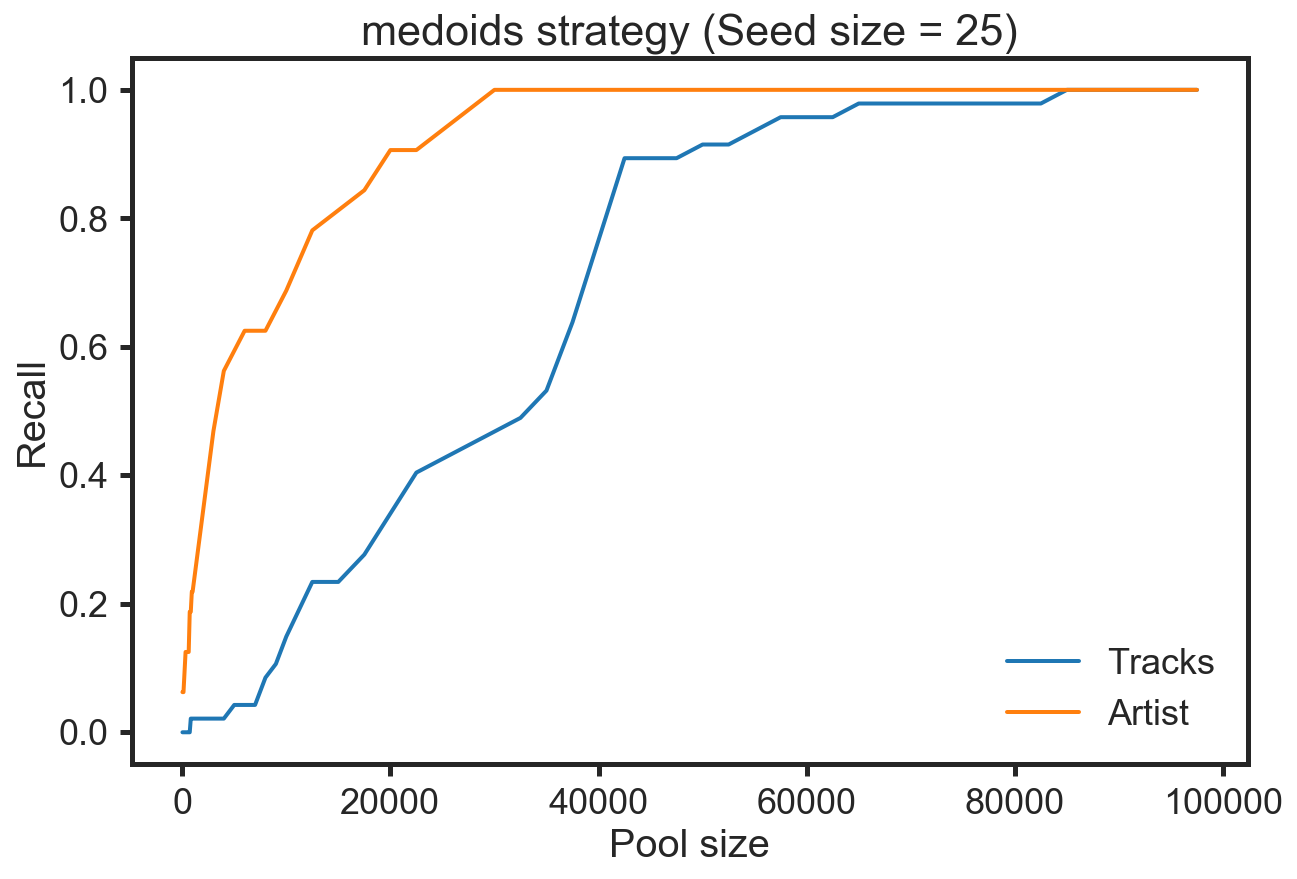

In [12]:
import matplotlib.pyplot as plt
plt.plot(stats_df['n'],stats_df['recall_tracks'],label='Tracks')
plt.plot(stats_df['n'],stats_df['recall_artist'],label='Artist')
plt.ylabel('Recall')
plt.xlabel('Pool size')
plt.title('{} strategy (Seed size = {})'.format(strat,k))
plt.legend()
plt.show()

# several random playlists

In [27]:
pooler.verbose=False
ks = [5, 10, 25, 100]
stats=[]
pids = [i for i in np.random.randint(0,5000,1000)]
n_picks = [10000]
strats=['mean','centroids','medoids','split']
product_n = product_size([ks,pids,n_picks,strats])
#for pid in :
for combo in tqdm(product(*[strats,n_picks,pids,ks]),total=product_n):
    try:
        strat,n_pick,pid,k = combo
        pl_turi,pl_auri = tracks.get_playlist(pid)
        if len(pl_turi) > k:
            seeds_t = pl_turi[:k]
            true_t,true_a = pl_turi[k:],pl_auri[k:]
            pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
            pool_a = [tracks.turi2auri[t] for t in pool_t]
            stats.append(pool_stats(pid,k,strat,i,true_t,pool_t,true_a,pool_a))
    except (ValueError,TypeError,UnboundLocalError) as e:
        print('Error with {}'.format(combo))

  1%|          | 127/16000 [00:04<08:56, 29.56it/s]/home/beangoben/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/beangoben/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  1%|          | 135/16000 [00:04<08:41, 30.43it/s]

Error with ('mean', 10000, 684, 5)
Error with ('mean', 10000, 684, 10)
Error with ('mean', 10000, 684, 25)


  5%|▌         | 838/16000 [00:29<08:45, 28.86it/s]

Error with ('mean', 10000, 684, 5)
Error with ('mean', 10000, 684, 10)
Error with ('mean', 10000, 684, 25)


  5%|▌         | 867/16000 [00:29<08:43, 28.91it/s]

Error with ('mean', 10000, 1985, 5)
Error with ('mean', 10000, 1985, 10)
Error with ('mean', 10000, 1985, 25)
Error with ('mean', 10000, 1769, 5)


 10%|▉         | 1590/16000 [00:54<08:16, 29.04it/s]

Error with ('mean', 10000, 4064, 5)


 12%|█▏        | 1977/16000 [01:07<07:59, 29.23it/s]

Error with ('mean', 10000, 684, 5)
Error with ('mean', 10000, 684, 10)
Error with ('mean', 10000, 684, 25)


 17%|█▋        | 2666/16000 [01:31<07:37, 29.14it/s]

Error with ('mean', 10000, 2672, 5)


 20%|█▉        | 3165/16000 [01:47<07:15, 29.49it/s]

Error with ('mean', 10000, 534, 5)


 24%|██▎       | 3777/16000 [02:07<06:51, 29.72it/s]

Error with ('mean', 10000, 2631, 5)
Error with ('mean', 10000, 2631, 10)


 24%|██▍       | 3867/16000 [02:10<06:48, 29.72it/s]

Error with ('mean', 10000, 3202, 5)


 24%|██▍       | 3910/16000 [02:11<06:46, 29.71it/s]

Error with ('mean', 10000, 4201, 5)
Error with ('mean', 10000, 4201, 10)


 26%|██▌       | 4128/16000 [02:25<06:59, 28.33it/s]/home/beangoben/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/beangoben/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/beangoben/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/beangoben/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:314: RuntimeWarning: Mean of empty slice.
  X_mean = X.mean(axis=0)


Error with ('centroids', 10000, 684, 5)
Error with ('centroids', 10000, 684, 10)
Error with ('centroids', 10000, 684, 25)


 30%|███       | 4831/16000 [03:31<08:08, 22.88it/s]

Error with ('centroids', 10000, 684, 5)
Error with ('centroids', 10000, 684, 10)
Error with ('centroids', 10000, 684, 25)


 30%|███       | 4865/16000 [03:34<08:11, 22.66it/s]

Error with ('centroids', 10000, 1985, 5)
Error with ('centroids', 10000, 1985, 10)


 37%|███▋      | 5974/16000 [05:24<09:04, 18.40it/s]

Error with ('centroids', 10000, 684, 5)
Error with ('centroids', 10000, 684, 10)
Error with ('centroids', 10000, 684, 25)


 45%|████▍     | 7161/16000 [07:16<08:58, 16.42it/s]

Error with ('centroids', 10000, 534, 5)


 49%|████▉     | 7907/16000 [08:32<08:44, 15.43it/s]

Error with ('centroids', 10000, 4201, 5)
Error with ('centroids', 10000, 4201, 10)


 51%|█████     | 8134/16000 [08:55<08:38, 15.18it/s]

Error with ('medoids', 10000, 684, 5)
Error with ('medoids', 10000, 684, 10)
Error with ('medoids', 10000, 684, 25)


 53%|█████▎    | 8416/16000 [09:22<08:27, 14.96it/s]

Error with ('medoids', 10000, 255, 5)


 55%|█████▌    | 8831/16000 [10:02<08:09, 14.65it/s]

Error with ('medoids', 10000, 684, 5)
Error with ('medoids', 10000, 684, 10)
Error with ('medoids', 10000, 684, 25)


 55%|█████▌    | 8866/16000 [10:05<08:07, 14.64it/s]

Error with ('medoids', 10000, 1985, 5)
Error with ('medoids', 10000, 1985, 10)
Error with ('medoids', 10000, 1985, 25)


 55%|█████▌    | 8873/16000 [10:06<08:06, 14.64it/s]

Error with ('medoids', 10000, 1769, 5)


 56%|█████▌    | 8962/16000 [10:14<08:02, 14.58it/s]

Error with ('medoids', 10000, 2449, 5)


 57%|█████▋    | 9190/16000 [10:36<07:51, 14.44it/s]

Error with ('medoids', 10000, 216, 5)


 59%|█████▊    | 9369/16000 [10:53<07:42, 14.33it/s]

Error with ('medoids', 10000, 198, 5)


 60%|█████▉    | 9539/16000 [11:11<07:34, 14.20it/s]

Error with ('medoids', 10000, 4716, 5)


 60%|█████▉    | 9590/16000 [11:16<07:32, 14.17it/s]

Error with ('medoids', 10000, 4064, 5)
Error with ('medoids', 10000, 2950, 5)


 61%|██████    | 9739/16000 [11:30<07:23, 14.11it/s]

Error with ('medoids', 10000, 4559, 5)
Error with ('medoids', 10000, 4559, 10)


 62%|██████▏   | 9974/16000 [11:50<07:09, 14.03it/s]

Error with ('medoids', 10000, 684, 5)
Error with ('medoids', 10000, 684, 10)
Error with ('medoids', 10000, 684, 25)


 63%|██████▎   | 10045/16000 [11:57<07:05, 14.00it/s]

Error with ('medoids', 10000, 4646, 5)


 64%|██████▎   | 10185/16000 [12:10<06:56, 13.94it/s]

Error with ('medoids', 10000, 2406, 5)


 66%|██████▋   | 10628/16000 [12:50<06:29, 13.80it/s]

Error with ('medoids', 10000, 3196, 5)


 67%|██████▋   | 10660/16000 [12:52<06:27, 13.80it/s]

Error with ('medoids', 10000, 2672, 5)


 67%|██████▋   | 10775/16000 [13:03<06:20, 13.74it/s]

Error with ('medoids', 10000, 2285, 5)


 70%|██████▉   | 11165/16000 [13:39<05:54, 13.62it/s]

Error with ('medoids', 10000, 534, 5)
Error with ('medoids', 10000, 534, 10)


 70%|███████   | 11221/16000 [13:44<05:51, 13.61it/s]

Error with ('medoids', 10000, 4646, 5)


 73%|███████▎  | 11756/16000 [14:34<05:15, 13.45it/s]

Error with ('medoids', 10000, 3540, 5)


 74%|███████▎  | 11775/16000 [14:35<05:14, 13.44it/s]

Error with ('medoids', 10000, 2631, 5)
Error with ('medoids', 10000, 2631, 10)


 74%|███████▍  | 11864/16000 [14:45<05:08, 13.40it/s]

Error with ('medoids', 10000, 3202, 5)


 74%|███████▍  | 11907/16000 [14:49<05:05, 13.38it/s]

Error with ('medoids', 10000, 4201, 5)
Error with ('medoids', 10000, 4201, 10)


 76%|███████▌  | 12133/16000 [15:48<05:02, 12.80it/s]

Error with ('split', 10000, 684, 5)
Error with ('split', 10000, 684, 10)
Error with ('split', 10000, 684, 25)


 80%|████████  | 12837/16000 [20:45<05:06, 10.30it/s]

Error with ('split', 10000, 684, 5)
Error with ('split', 10000, 684, 10)
Error with ('split', 10000, 684, 25)


 80%|████████  | 12865/16000 [20:58<05:06, 10.22it/s]

Error with ('split', 10000, 1985, 5)
Error with ('split', 10000, 1985, 10)


 87%|████████▋ | 13973/16000 [28:26<04:07,  8.19it/s]

Error with ('split', 10000, 684, 5)
Error with ('split', 10000, 684, 10)
Error with ('split', 10000, 684, 25)


 95%|█████████▍| 15155/16000 [36:02<02:00,  7.01it/s]

Error with ('split', 10000, 534, 5)


 99%|█████████▉| 15903/16000 [41:06<00:15,  6.45it/s]

Error with ('split', 10000, 4201, 5)
Error with ('split', 10000, 4201, 10)


100%|██████████| 16000/16000 [41:51<00:00,  6.37it/s]


## Results

/home/beangoben/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


pid  recall-tracks  recall-artist
                    count     mean (std)     mean (std)
k   strategy  n                                        
5   centroids 22500   989  0.683 (0.247)  0.861 (0.160)
    mean      22500   984  0.703 (0.256)  0.869 (0.162)
    medoids   22500   971  0.624 (0.264)  0.840 (0.182)
    split     22500   989  0.636 (0.252)  0.844 (0.163)
10  centroids 22500   956  0.698 (0.241)  0.872 (0.155)
    mean      22500   955  0.726 (0.248)  0.877 (0.163)
    medoids   22500   953  0.630 (0.261)  0.846 (0.172)
    split     22500   956  0.648 (0.247)  0.851 (0.161)
25  centroids 22500   769  0.723 (0.231)  0.885 (0.137)
    mean      22500   768  0.740 (0.243)  0.889 (0.147)
    medoids   22500   768  0.636 (0.255)  0.855 (0.156)
    split     22500   769  0.662 (0.229)  0.853 (0.152)
100 centroids 22500   210  0.681 (0.245)  0.890 (0.150)
    mean      22500   210  0.722 (0.243)  0.894 (0.163)
    medoids   22500   210  0.614 (0.256)  0.863 (0.161)
    split     22500   210  0.630 (0.225)  0.852 (0.169)

/home/beangoben/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/home/beangoben/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:895: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])
/home/beangoben/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:915: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


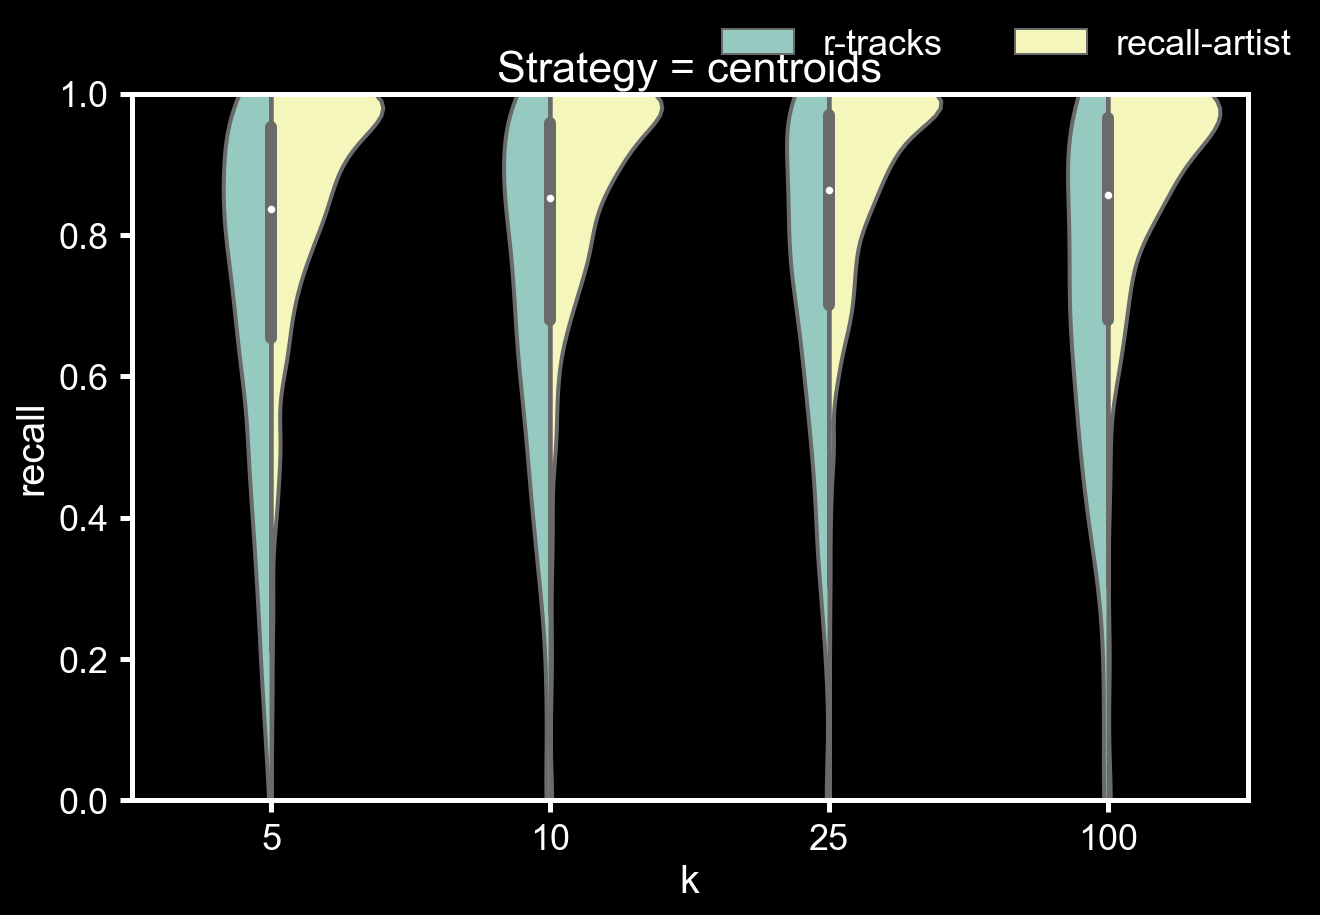

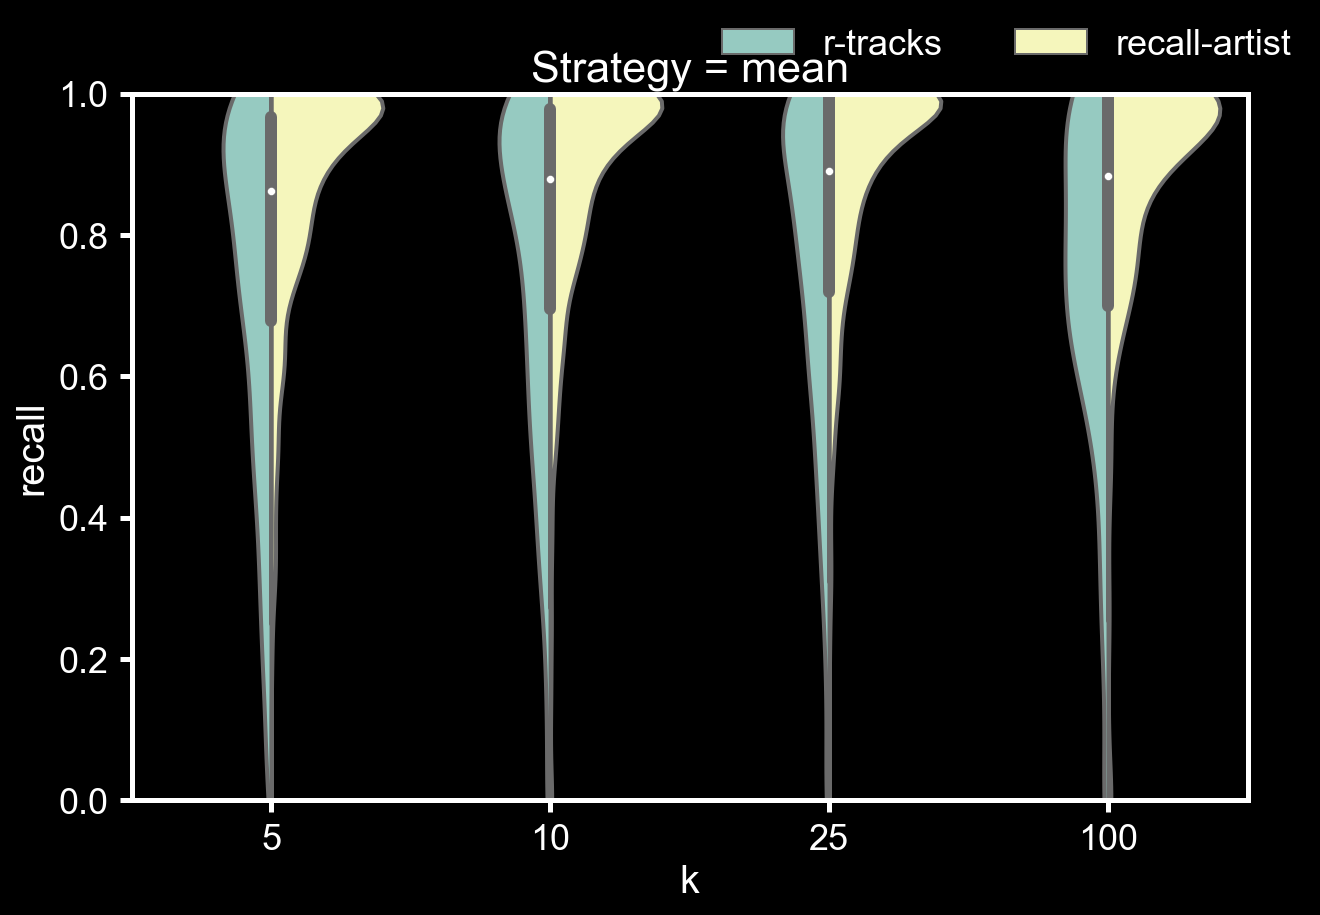

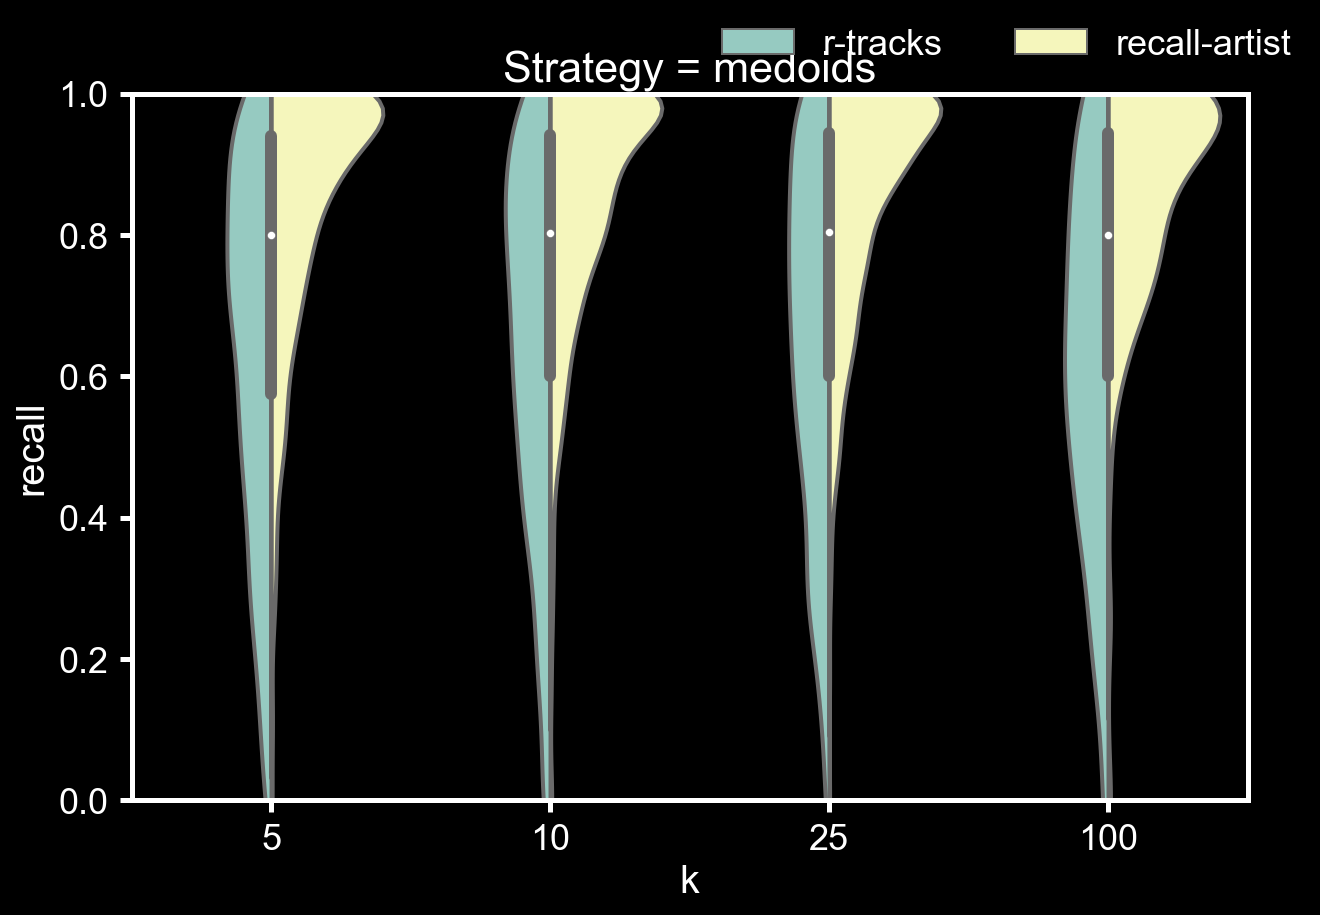

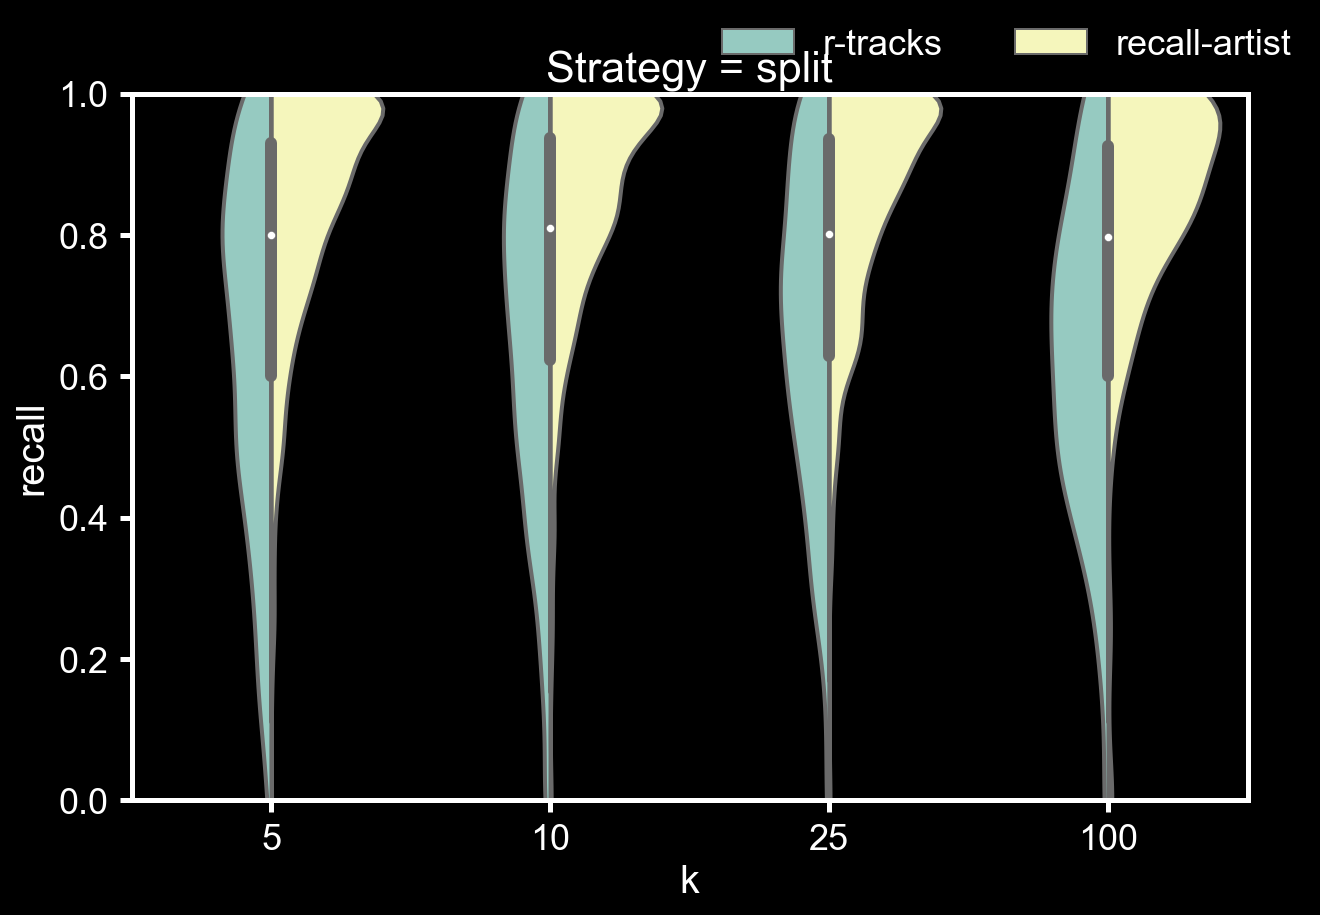

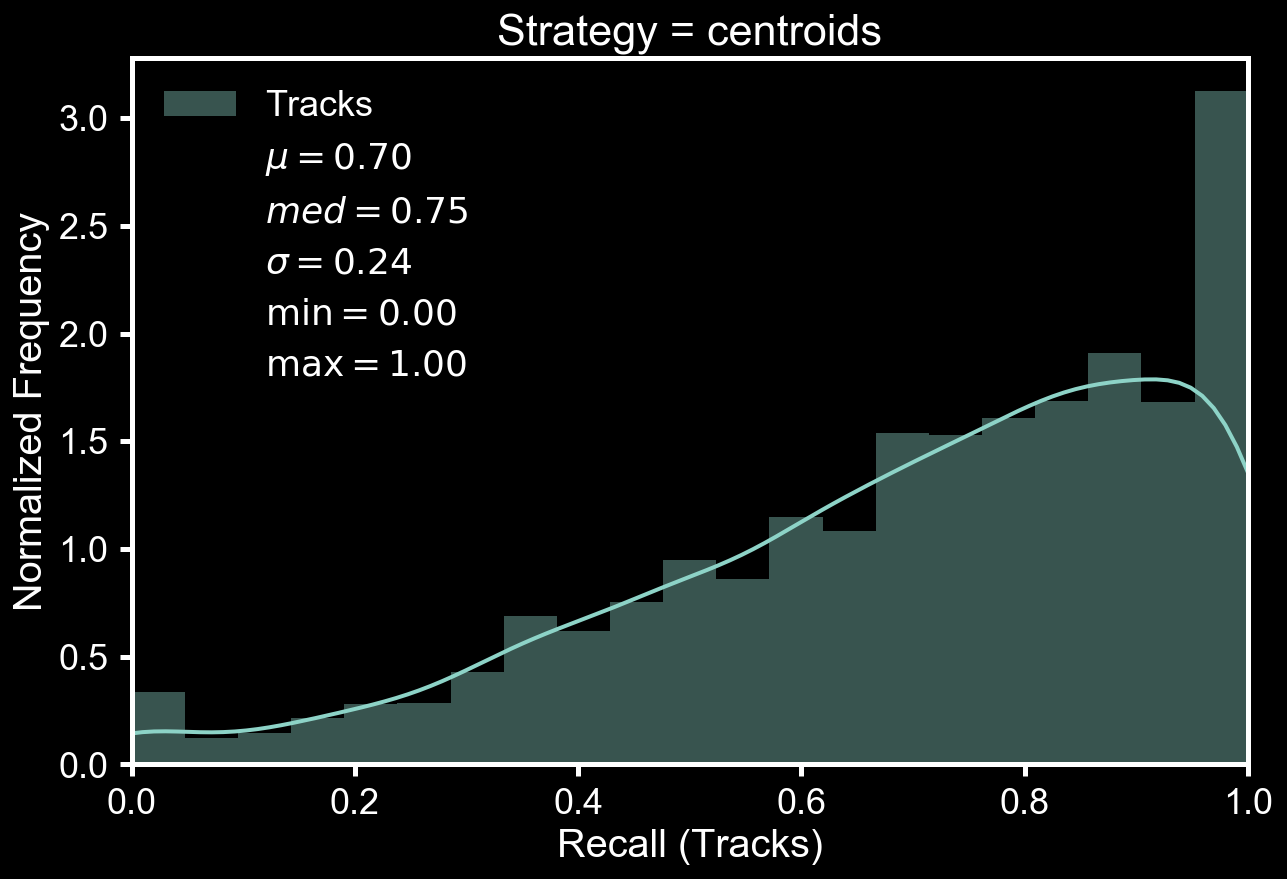

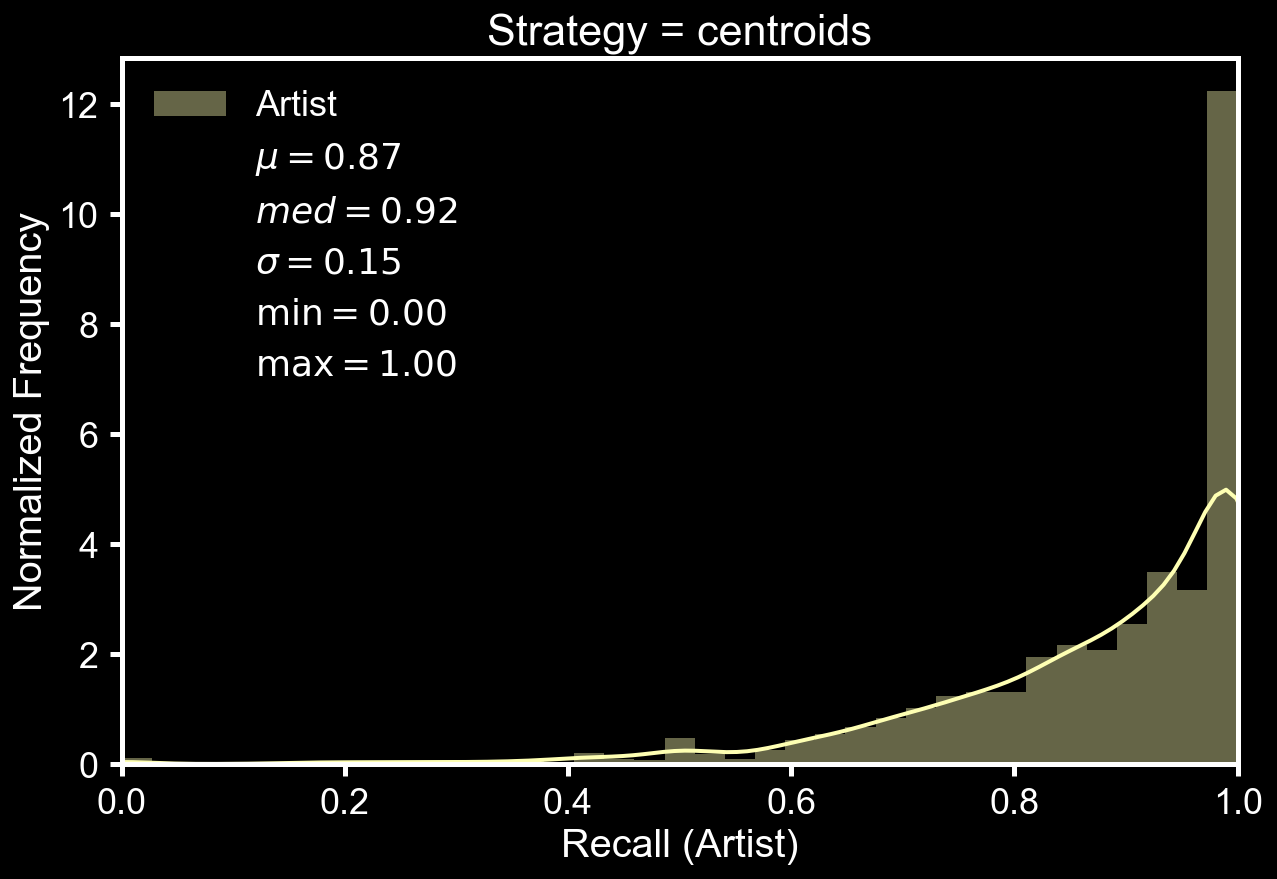

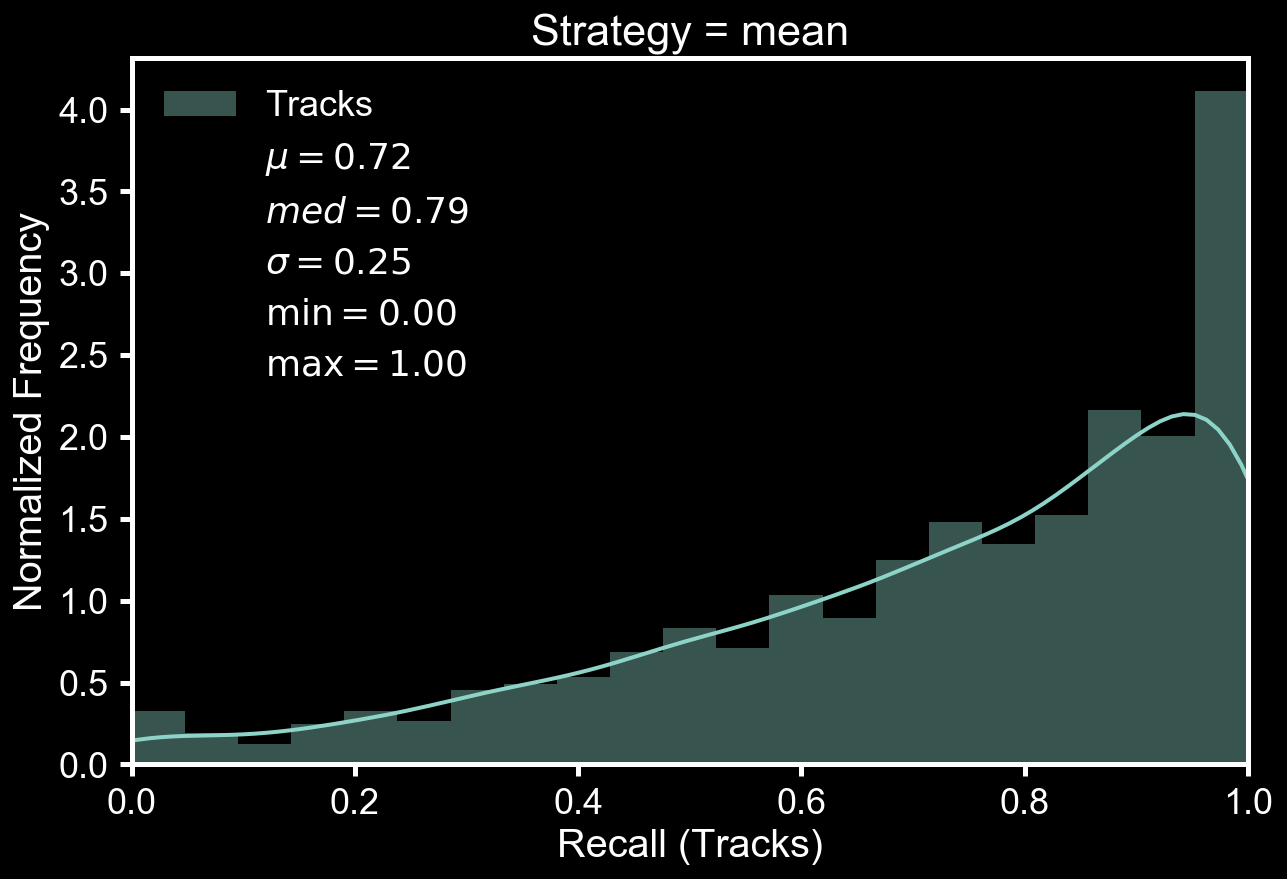

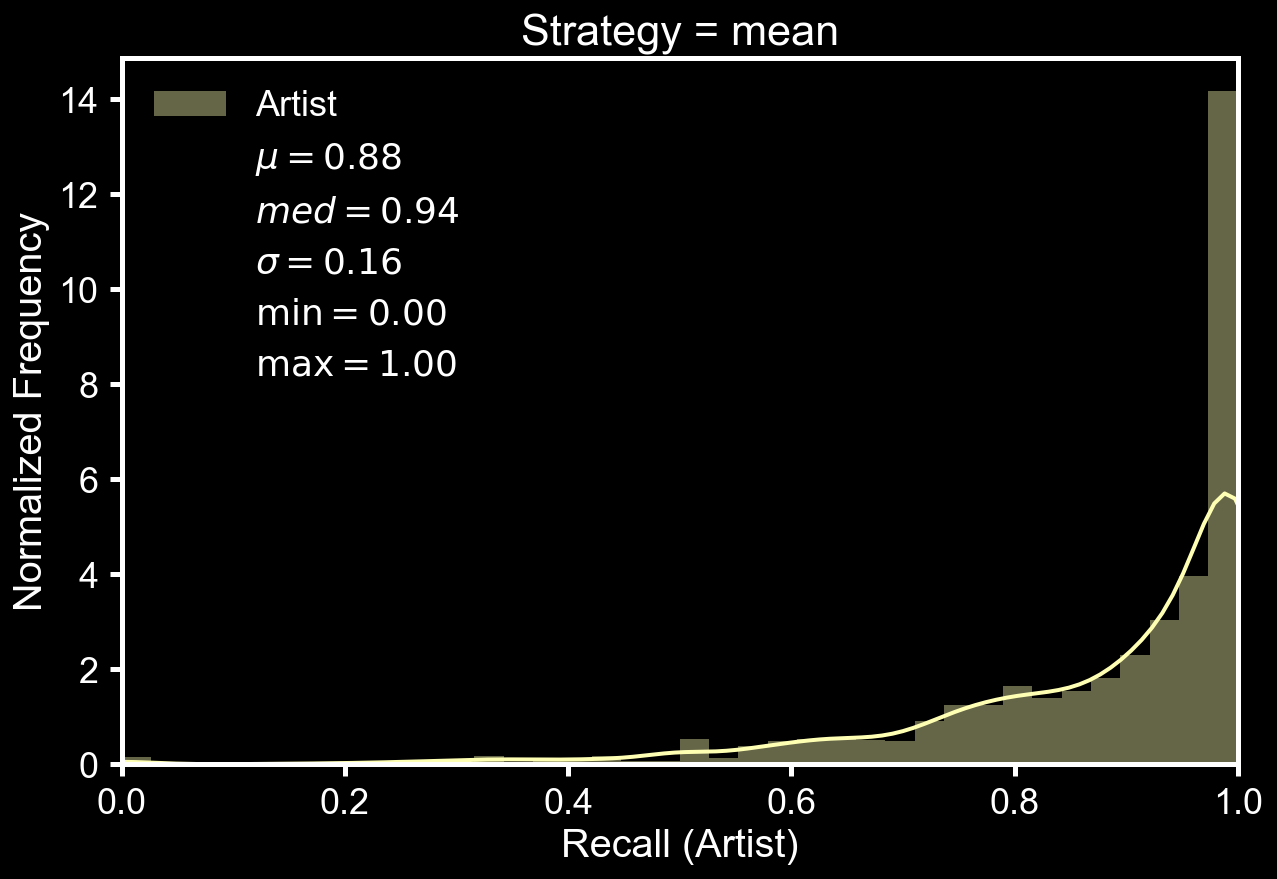

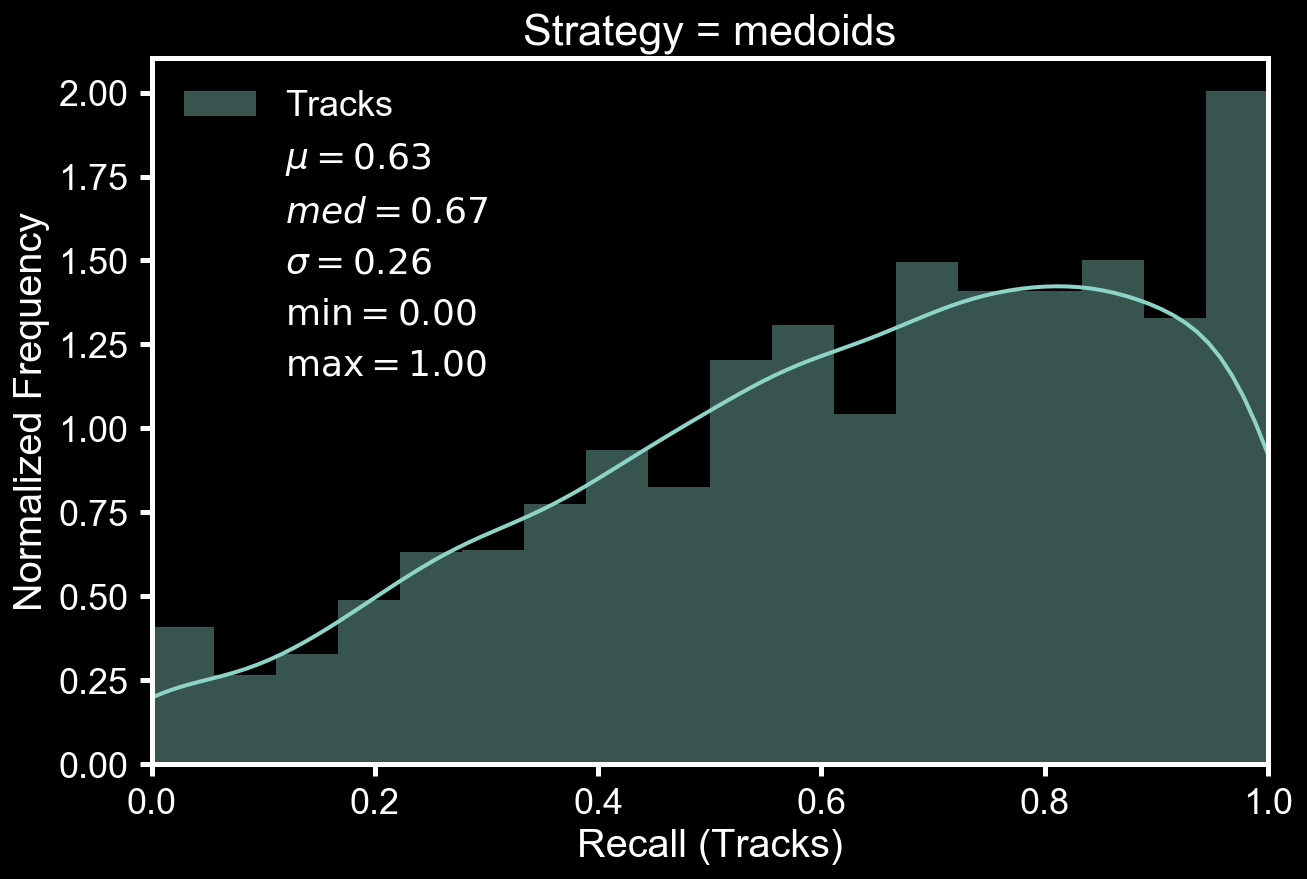

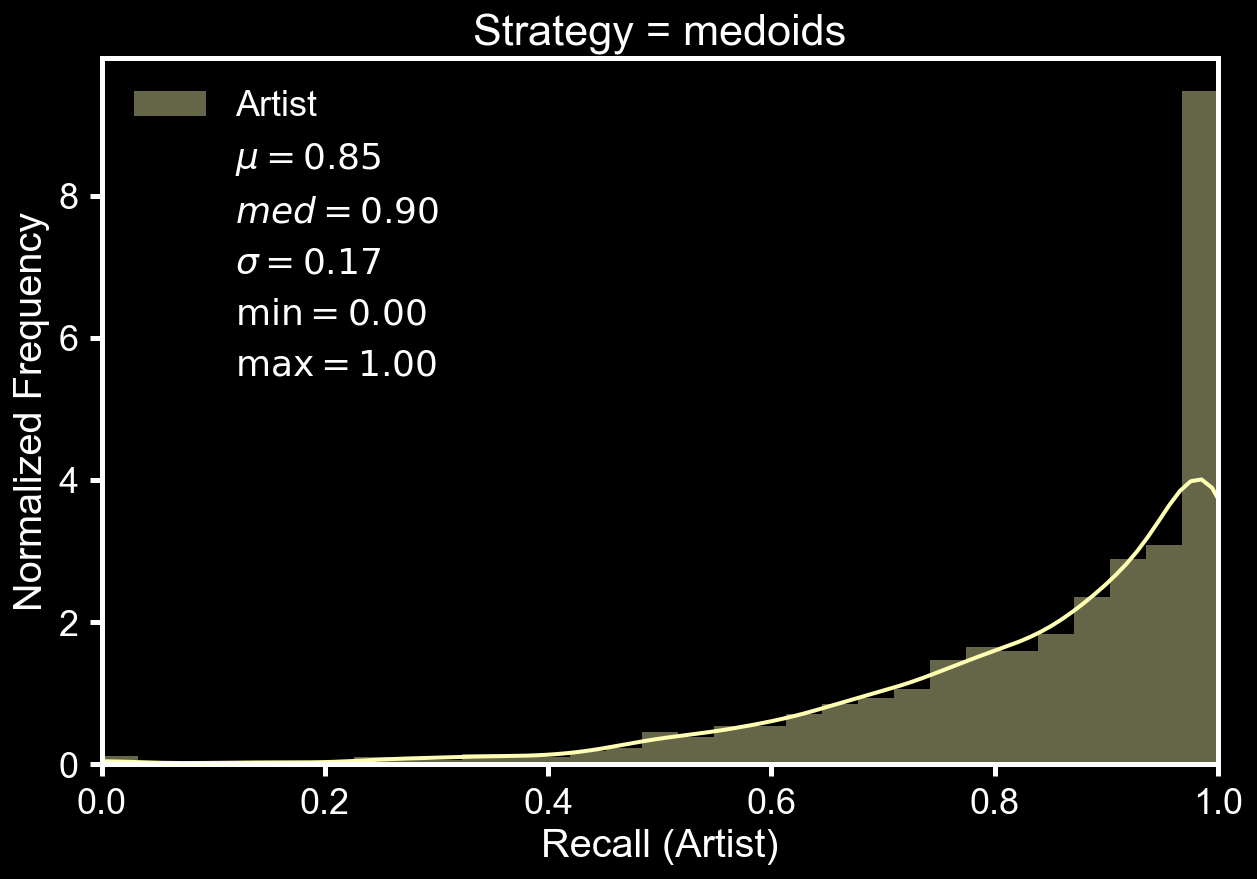

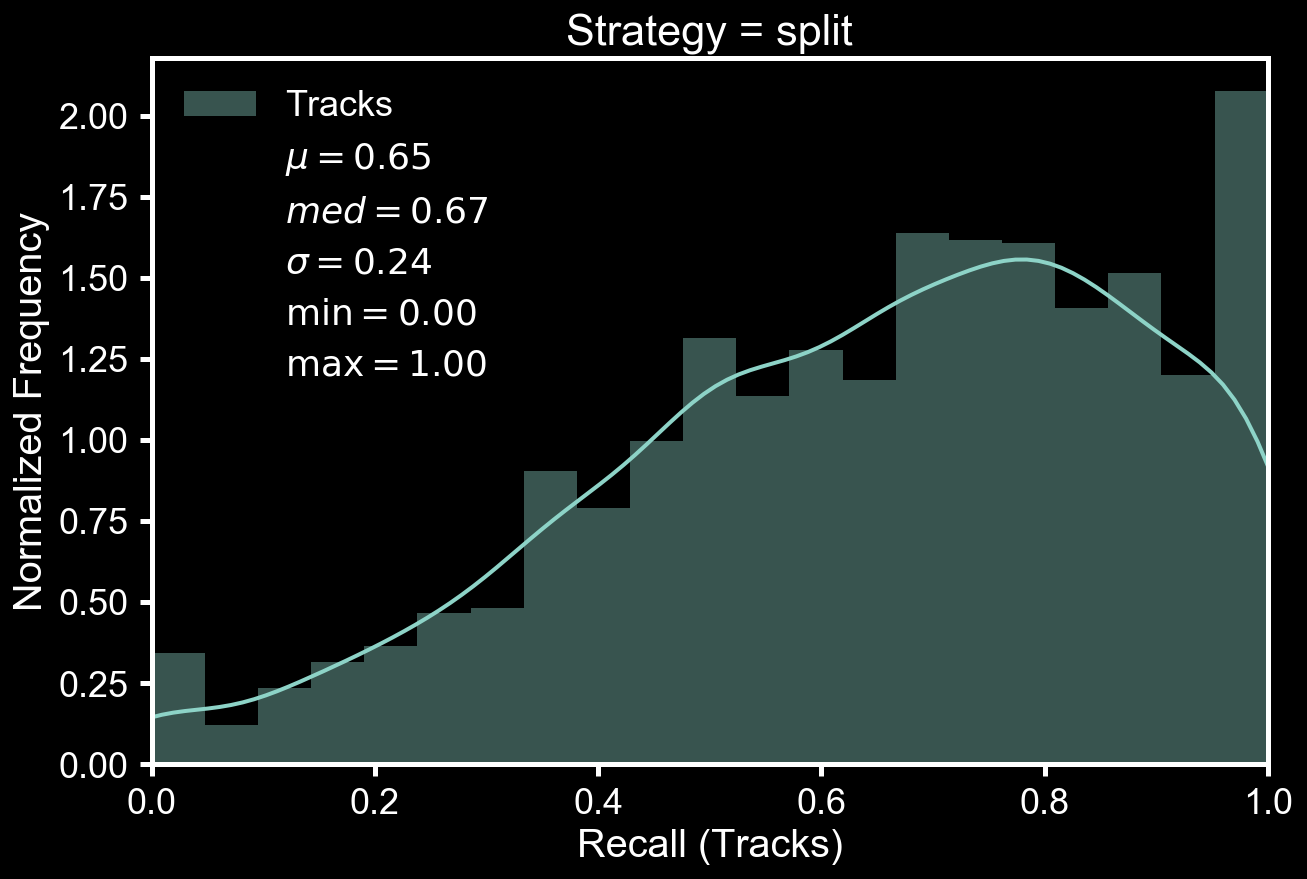

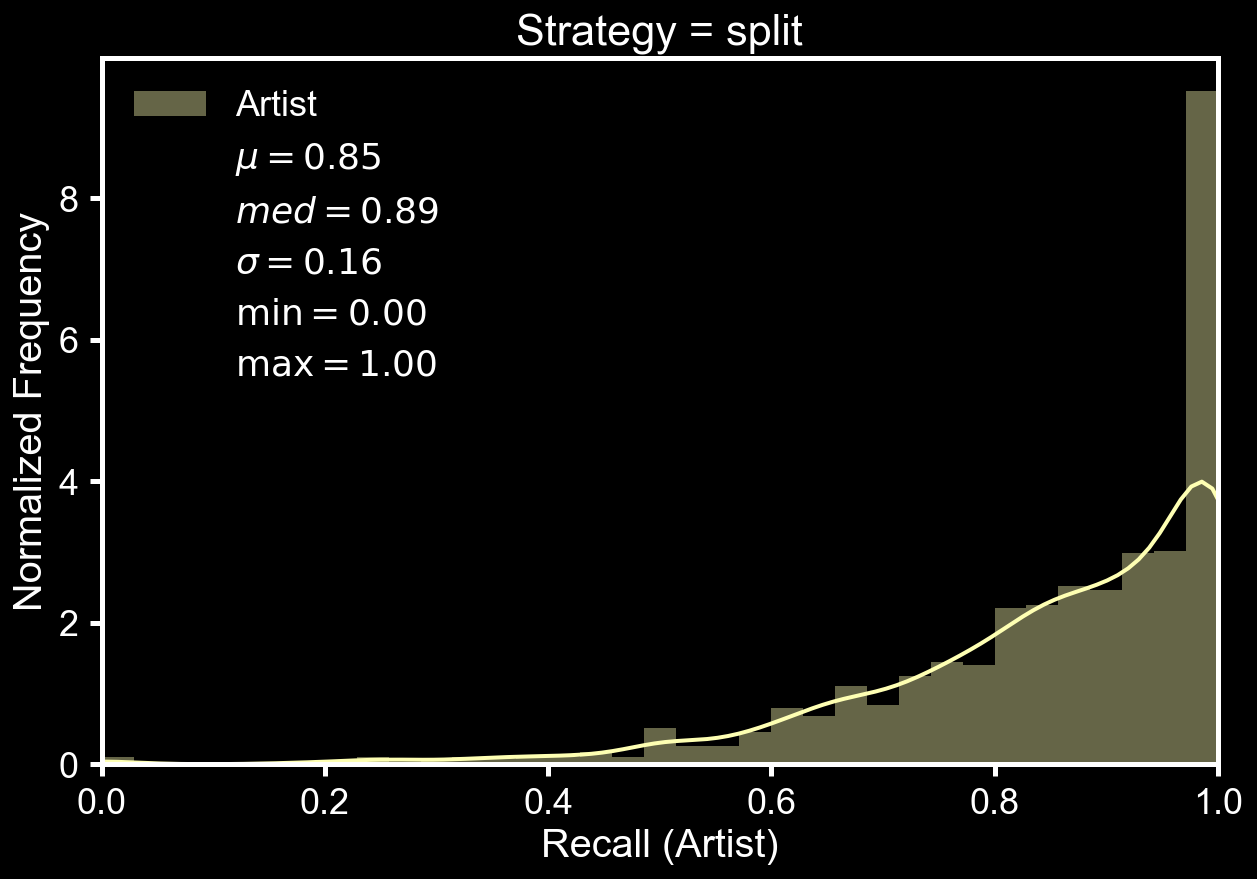

In [28]:
summ_df = summary_pooling_table(stats)
write_latex_table(summ_df,'pooling',adir='../reports')
display(summ_df)
pooling_plots(stats)

# How big of a pool do we need (on average)?

In [29]:
pooler.verbose=False
ks = [100]
stats=[]
pids = [i for i in np.random.randint(0,5000,2000)]
n_picks = [25000]
pool_range = list(range(25,1000,100))+list(range(1000,10000,1000))+list(range(10000,n_picks[0],2500))
strats=['mean','centroids','medoids','wcentroids','wmedoids','split']
product_n = product_size([strats,n_picks,pids,ks])
stats=[]
#for pid in :
for combo in tqdm(product(*[strats,n_picks,pids,ks]),total=product_n):
    try:
        strat,n_pick,pid,k = combo
        pl_turi,pl_auri = tracks.get_playlist(pid)
        if len(pl_turi) > k:
            seeds_t = pl_turi[:k]
            true_t,true_a = pl_turi[k:],pl_auri[k:]
            pool_t, dist= pooler.recommend(seeds_t,n=n_pick,agg_strat=strat)
            pool_a = [tracks.turi2auri[t] for t in pool_t]
            for i in pool_range:
                stats.append(pool_stats(pid,k,strat,i,true_t,pool_t[:i],true_a,pool_a[:i]))
    except ValueError as e:
        print('Error with {}'.format(combo))
# random test
for combo in product(*[pids,ks]):
    pid,k = combo
    pl_turi,pl_auri = tracks.get_playlist(pid)
    if len(pl_turi) > k:
        seeds_t = pl_turi[:k]
        true_t,true_a = pl_turi[k:],pl_auri[k:]
        for i in pool_range:
            pool_t,pool_a = tracks.random_tracks(i,exclude=seeds_t)
            stats.append(pool_stats(pid,k,'random',i,true_t,pool_t,true_a,pool_a))

stats_df = pd.DataFrame(stats)
stats_df.head()

100%|██████████| 12000/12000 [30:27<00:00,  6.57it/s]


,pid,k,strategy,n,recall-tracks,recall-artist
0,2219,100,mean,25,0.03,0.09
1,2219,100,mean,125,0.03,0.24
2,2219,100,mean,225,0.05,0.31
3,2219,100,mean,325,0.12,0.36
4,2219,100,mean,425,0.15,0.40


## results

/home/beangoben/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


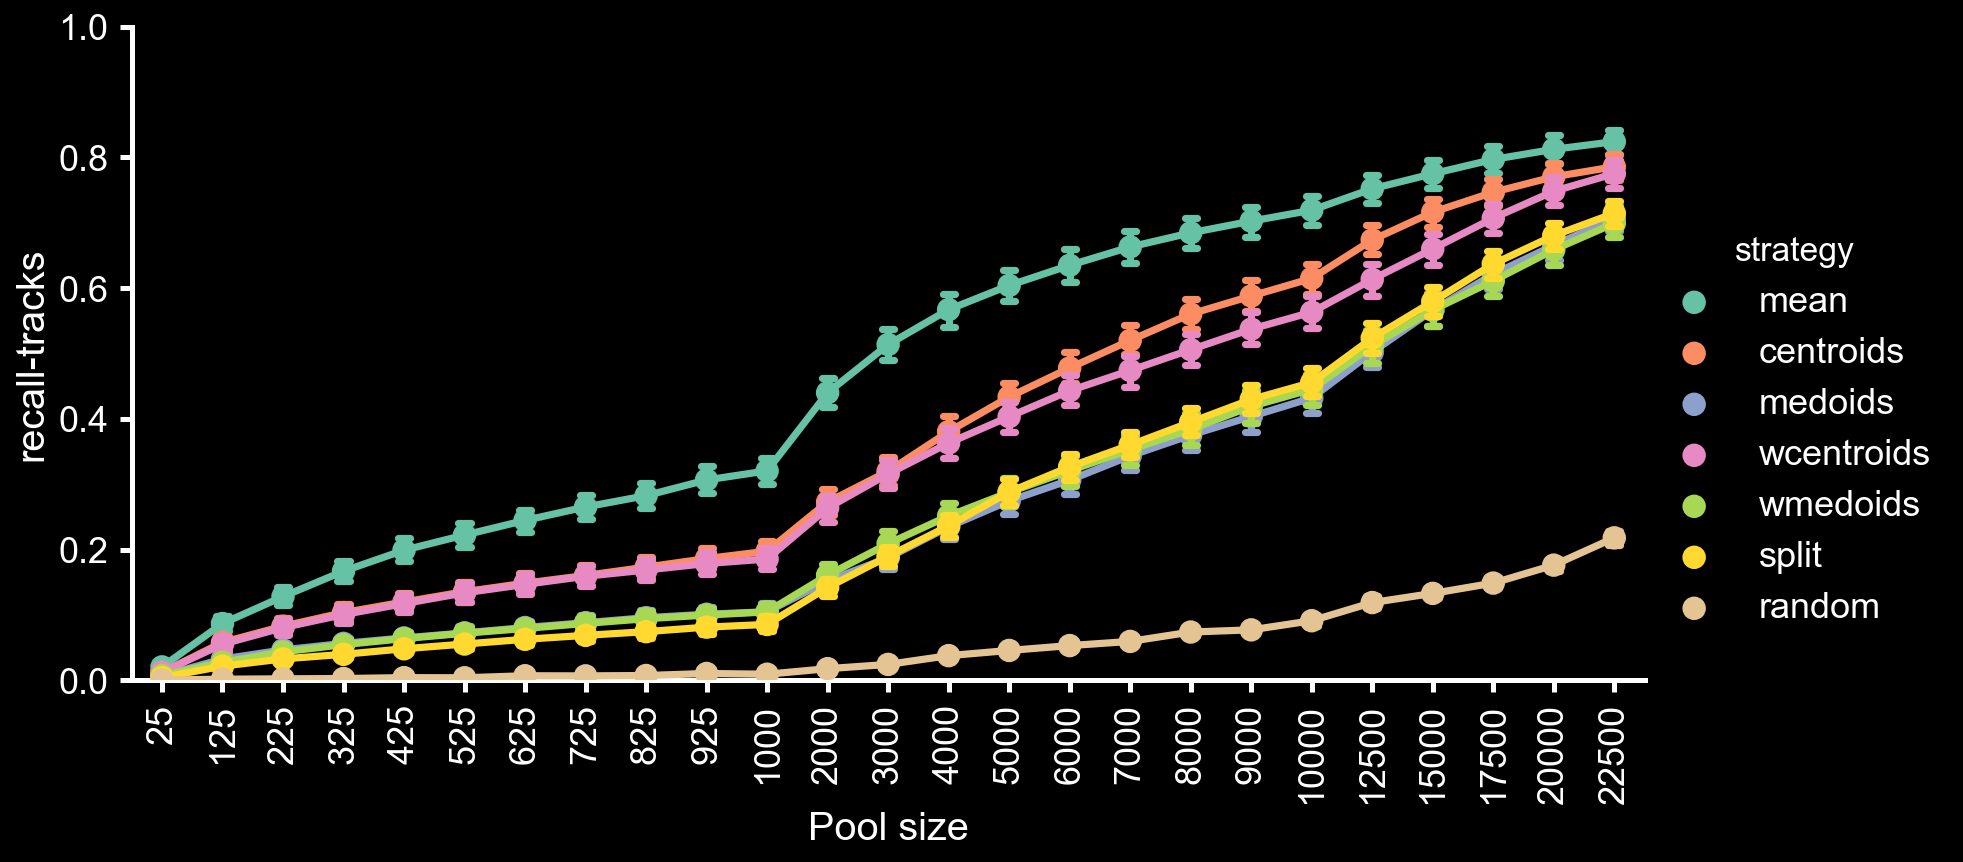

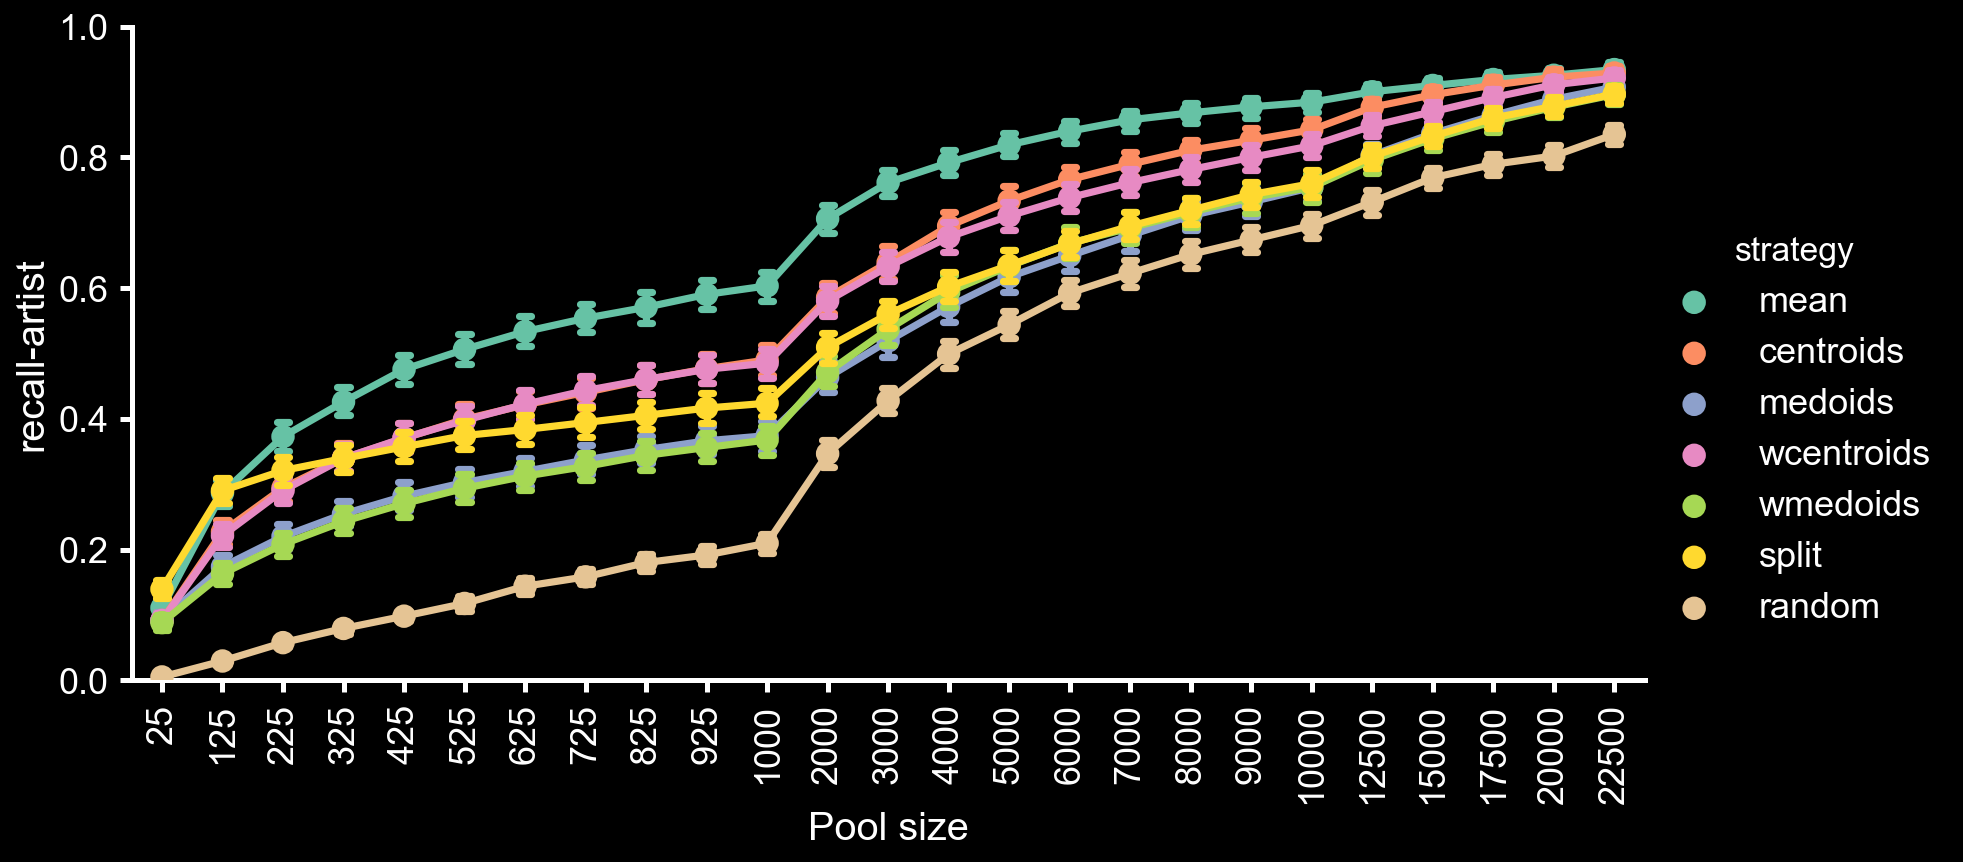

In [30]:
plt.style.use('dark_background')
sns.factorplot(x="n", y="recall-tracks", hue="strategy", data=stats_df,
                   capsize=.2, palette="Set2", size=6, aspect=2)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.xlabel('Recall (Track)')
plt.xlabel('Pool size')
plt.savefig('../reports/pool_size_tracks.svg')
plt.savefig('../reports/pool_size_tracks.png',dpi=300)
plt.show()
sns.factorplot(x="n", y="recall-artist", hue="strategy", data=stats_df,
                   capsize=.2, palette="Set2", size=6, aspect=2,alpha=0.75)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.xlabel('Recall (Artist)')
plt.xlabel('Pool size')
plt.savefig('../reports/pool_size_artist.svg')
plt.savefig('../reports/pool_size_artist.png',dpi=300)
plt.show()